# 第六章 其他的CV问题

In [1]:
#hide
from fastbook import *

In [2]:
from fastai.vision.all import *
path = untar_data(URLs.PASCAL_2007)

In [3]:
df = pd.read_csv(path/'train.csv')
df.head()
dblock = DataBlock(get_x = lambda r: r['fname'], get_y = lambda r: r['labels'])
dsets=dblock.datasets(df)
x,y=dsets.train[0]
x,y

('008663.jpg', 'car person')

In [4]:
len(dsets.train),len(dsets.valid)

(4009, 1002)

In [5]:
dblock = DataBlock(get_x = lambda r: r['fname'], get_y = lambda r: r['labels'])
dsets = dblock.datasets(df)
dsets.train[0]

('005620.jpg', 'aeroplane')

lambda表达式就是 lambda a(输入)：b(输出) lambda表达式是一个一次性的，python不会把这个匿名函数留下来。

In [6]:
def get_x(r): return path/'train'/r['fname']
def get_y(r): return r['labels'].split(' ')
dblock = DataBlock(blocks=(ImageBlock, MultiCategoryBlock),
                   get_x = get_x, get_y = get_y)
dsets = dblock.datasets(df)
dsets.train[0]

(PILImage mode=RGB size=500x375,
 TensorMultiCategory([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]))

注意这里的返回值，前面一部分的返回值是自变量，也就是这样的一张图片，后面的一部分是它的分类信息，使用了独热编码来对其进行编码。

In [7]:
def splitter(df):
    train = df.index[~df['is_valid']].tolist()
    valid = df.index[df['is_valid']].tolist()
    return train,valid

dblock = DataBlock(blocks=(ImageBlock, MultiCategoryBlock),
                   splitter=splitter,
                   get_x=get_x, 
                   get_y=get_y)

dsets = dblock.datasets(df)
dsets.train[0]

(PILImage mode=RGB size=500x333,
 TensorMultiCategory([0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]))

这里向这个类中传入了一个splitter函数，这个函数的作用是返回索引中存在'is_valid' 的记录作为训练集，而没有'is_vaild'的记录作为测试集

In [8]:
dblock = DataBlock(blocks=(ImageBlock, MultiCategoryBlock),
                   splitter=splitter,
                   get_x=get_x, 
                   get_y=get_y,
                   item_tfms = RandomResizedCrop(128, min_scale=0.35))      #保证图像大小统一
dls = dblock.dataloaders(df)

到此为止，数据集的预处理完毕了

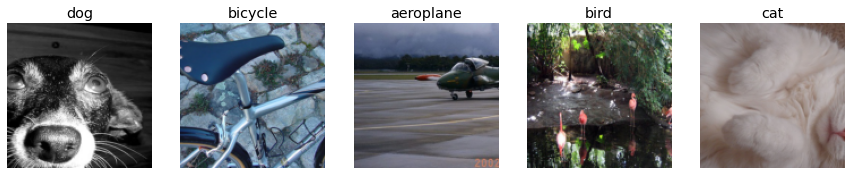

In [9]:
dls.show_batch(nrows=1, ncols=5)

接下来就开始创建一个训练器了，这个训练器用的是18层的模型

In [10]:
learn = cnn_learner(dls, resnet18)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to C:\Users\94323/.cache\torch\hub\checkpoints\resnet18-5c106cde.pth
100%|██████████| 44.7M/44.7M [02:10<00:00, 358kB/s] 


In [22]:
x,y = to_cpu(dls.train.one_batch())
activs = learn.model(x)
activs.shape

NameError: name 'learn' is not defined

## 图像回归问题

使用的数据集是BIWI，[Biwi Kinect Head Pose dataset](https://icu.ee.ethz.ch/research/datsets.html)

In [11]:
path = untar_data(URLs.BIWI_HEAD_POSE)

In [12]:
Path.BASE_PATH= path

In [13]:
path.ls().sorted()

(#50) [Path('01'),Path('01.obj'),Path('02'),Path('02.obj'),Path('03'),Path('03.obj'),Path('04'),Path('04.obj'),Path('05'),Path('05.obj')...]

In [14]:
img_files = get_image_files(path)
def img2pose(x): return Path(f'{str(x)[:-7]}pose.txt')
img2pose(img_files[0])

Path('01/frame_00003_pose.txt')

In [15]:
cal = np.genfromtxt(path/'01'/'rgb.cal', skip_footer=6)
def get_ctr(f):                                                         #找到图像中心的函数
    ctr = np.genfromtxt(img2pose(f), skip_header=3)
    c1 = ctr[0] * cal[0][0]/ctr[2] + cal[0][2]
    c2 = ctr[1] * cal[1][1]/ctr[2] + cal[1][2]
    return tensor([c1,c2])

创建一个代码块，一部分是图像的block，一部分的是点的block，x轴是图像的文件名，y轴是图像中心的坐标。splitter是将编号13文件下面的人像作为验证集

In [25]:
biwi = DataBlock(
    blocks=(ImageBlock, PointBlock),
    get_items=get_image_files,
    get_y=get_ctr,
    splitter=FuncSplitter(lambda o: o.parent.name=='13'),
    batch_tfms=[*aug_transforms(size=(240,320)),            #增强
                Normalize.from_stats(*imagenet_stats)]      #归一化
)

SyntaxError: invalid syntax (<ipython-input-25-0ec8250cb7cd>, line 7)

数据长这样

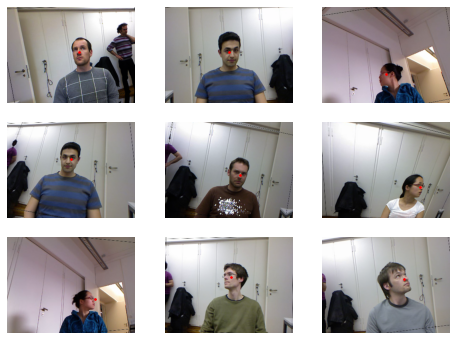

In [29]:
dls = biwi.dataloaders(path,num_workers=0)
dls.show_batch(max_n=9, figsize=(8,6))

In [28]:
biwi.dataloaders??

Signature:
biwi.dataloaders(
    source,
    path='.',
    verbose=False,
    bs=64,
    shuffle=False,
    num_workers=None,
    do_setup=True,
    pin_memory=False,
    timeout=0,
    batch_size=None,
    drop_last=False,
    indexed=None,
    n=None,
    device=None,
    persistent_workers=False,
    *,
    wif=None,
    before_iter=None,
    after_item=None,
    before_batch=None,
    after_batch=None,
    after_iter=None,
    create_batches=None,
    create_item=None,
    create_batch=None,
    retain=None,
    get_idxs=None,
    sample=None,
    shuffle_fn=None,
    do_batch=None,
)
Docstring: Create a `DataLoaders` object from `source`
Source:   
    def dataloaders(self, source, path='.', verbose=False, **kwargs):
        dsets = self.datasets(source, verbose=verbose)
        kwargs = {**self.dls_kwargs, **kwargs, 'verbose': verbose}
        return dsets.dataloaders(path=path, after_item=self.item_tfms, after_batch=self.batch_tfms, **kwargs)
File:      c:\users\94323\anaconda3\

In [18]:
xb,yb=dls.one_batch()
xb.shape,yb.shape

((64, 3, 240, 320), (64, 1, 2))

yb.shape的意思是每批次中有64张图片，还有一个中心点的位置向量的形状是（1，2）的，xb.shape的意思是每批次有64张图片，每张图片的大小是（240，320），3是这个图片的通道数，具体来说就是有RGB这三个通道组成，这里放的应该是RGB的信息。

In [20]:
yb[0],xb[0]

(TensorPoint([[-0.2197,  0.1022]], device='cuda:0'),
 TensorImage([[[ 0.0913,  0.0101, -0.0826,  ...,  0.0712,  0.0814,  0.0814],
          [-0.2025, -0.2304, -0.3778,  ...,  0.0764,  0.0624,  0.0624],
          [-0.5314, -0.6636, -0.7526,  ...,  0.0761,  0.0814,  0.0814],
          ...,
          [-1.6461, -1.9314, -2.0103,  ..., -0.3571, -0.3571, -0.3584],
          [-1.3349, -1.8769, -2.0081,  ..., -0.3571, -0.3571, -0.3689],
          [-1.3876, -1.8697, -2.0000,  ..., -0.3593, -0.3607, -0.3746]],
 
         [[ 0.0974, -0.0049,  0.0124,  ...,  0.0682,  0.0784,  0.0784],
          [-0.2348, -0.2629, -0.2388,  ...,  0.0735,  0.0595,  0.0515],
          [-0.5677, -0.7043, -0.7858,  ...,  0.0731,  0.0784,  0.0637],
          ...,
          [-1.7262, -1.8894, -1.9774,  ..., -0.3415, -0.3325, -0.3437],
          [-1.4971, -1.8353, -1.9747,  ..., -0.3424, -0.3298, -0.3542],
          [-1.5318, -1.8351, -1.9673,  ..., -0.3446, -0.3307, -0.3598]],
 
         [[ 0.1151, -0.0391, -0.0857,  ...

接下来就是训练模型的时间了。这里用的是18层的网络，y的范围是-1到1之间

In [30]:
learn = cnn_learner(dls, resnet18, y_range=(-1,1))

这个y_range能起作用的原因是在sigmoid_range中的定义，返回一个x的sigmoid函数值再乘上上下界的差最后加上下界的值。

In [22]:
def sigmoid_range(x, lo, hi): return torch.sigmoid(x) * (hi-lo) + lo

In [23]:
dls.loss_func

FlattenedLoss of MSELoss()

模型的损失函数是MSELOSS函数

然后我们需要找一个好一点的学习率

SuggestedLRs(lr_min=0.006918309628963471, lr_steep=0.04786301031708717)

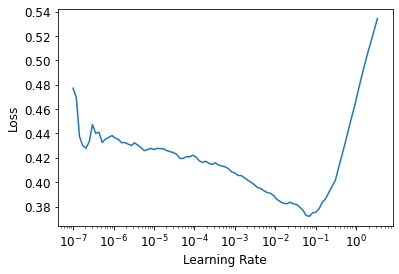

In [31]:
learn.lr_find()

根据最优梯度为最小值的1/10，我们选择1e-2作为优选

In [32]:
lr = 1e-2
learn.fine_tune(3, lr)

epoch,train_loss,valid_loss,time
0,0.007894,0.008485,04:38
1,0.002725,0.000379,04:38
2,0.001492,0.000162,04:46


最后这个得到的loss是没有开方的值，还需要开个方才是真正的loss

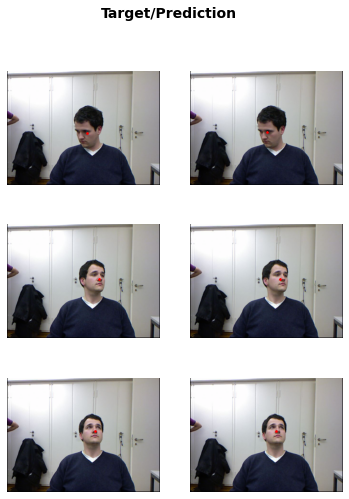

In [33]:
learn.show_results(ds_idx=1, nrows=3, figsize=(6,8))

可以看到结果还不错

## 总结

一些问题比较常用的loss函数
- `nn.CrossEntropyLoss` 用于单标签分类
- `nn.BCEWithLogitsLoss`用于多标签分类
- `nn.MSELoss` 用于回归